In [1]:
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

# 1. Binary Classification Task
First we want to compare the results of the classifiers on the binary classification task with the categories 'OFFENSE' and 'OTHER'. Additionally, we compare the germeval classifiers with the results of the Perspective API.

In [3]:
messages_collection = client.telegram.messages


def get_all_german_messages():
    query = {"language" : "de"}
    query_res = messages_collection.find(query, {"_id": 0, "text": 1, "hate_germeval_18": 1, "hate_germeval_19": 1, 
                                                "hate_germeval_1819": 1, "toxicity_score_preprocessed": 1, "toxicity_score": 1})
    messages = [msg for msg in query_res if msg['text'] is not None]
    return messages

In [4]:
messages = get_all_german_messages()
print('Number of messages: ', len(messages))

Number of messages:  5439691


In [5]:
def get_number_of_offensive_messages(messages, selected_dataset):
    count = 0
    for msg in messages:
        if msg[selected_dataset]['label'] != 'OTHER':
            count += 1
    return count

In [6]:
datasets = ['hate_germeval_18', 'hate_germeval_19', 'hate_germeval_1819']
for dataset in datasets:
    print(dataset, get_number_of_offensive_messages(messages, dataset))

hate_germeval_18 473170
hate_germeval_19 995268
hate_germeval_1819 316889


One can see that the classifiers are quite different. The one trained on both the Germeval 2018 and 2019 dataset is the most tolerant one, only 316.889 messages are classified as offensive. In contrast to that, the classifier that was trained only on the Germeval 2019 data, classified 995.268 messages as offensive, which is more than three times as much as the Germeval_1819 classifier. The third classifier which was trained only on the Germeval 2018 data has classified 473.170 messages as offensive.

In [7]:
def get_perspective_api_label(msg):
    toxicity_score = 0
    if 'toxicity_score_preprocessed' in msg:
        toxicity_score = msg['toxicity_score_preprocessed']
    else:
        toxicity_score = msg['toxicity_score']
        
    return 'OFFENSE' if toxicity_score >= 0.5 else 'OTHER'

def get_label(msg, classifier):
    if classifier == 'perspective_api':
        return get_perspective_api_label(msg)
    return msg[classifier]['label']

In [8]:
similarity_matrix = np.zeros((len(datasets) + 1, len(datasets) + 1))
for msg in messages:
    label_18 = get_label(msg, 'hate_germeval_18')
    label_19 = get_label(msg, 'hate_germeval_19')
    label_1819 = get_label(msg, 'hate_germeval_1819')
    label_perspective = get_label(msg, 'perspective_api')
    labels = [label_18, label_19, label_1819, label_perspective]
    for idx_1, label_1 in enumerate(labels):
        for idx_2, label_2 in enumerate(labels):
            if label_1 == label_2:
                similarity_matrix[idx_1][idx_2] += 1

similarity_matrix = similarity_matrix / len(messages)

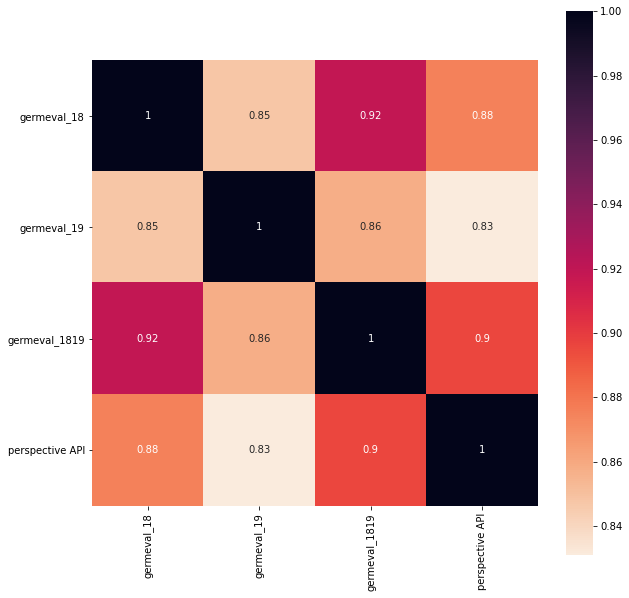

In [9]:
ticklabels = ['germeval_18', 'germeval_19', 'germeval_1819', 'perspective API']
ax = sns.heatmap(similarity_matrix, cmap='rocket_r', annot=True, square=True,xticklabels=ticklabels
                     , yticklabels=ticklabels)
figure = plt.gcf()
figure.set_size_inches(10, 10)
plt.show()

As one can see in the above plot, the classifiers agree in most of the cases. In particular, the germeval_18 and the germeval_1819 classifiers are quite similar, while the germeval_19 classifier is a little bit different. We already saw this difference in the number of offensive messages.

If one compares the results of the perspective API with the germeval classifiers, then one can see that they are also quite similar. Again the classifier trained on the germeval_19 dataset is the one that is the most different from the perspective API.

In [10]:
def get_confusion_matrix_binary(classifier_1, classifier_2):
    matrix = np.zeros((2, 2))
    for msg in messages:
        label_1 = get_label(msg, classifier_1)
        label_2 = get_label(msg, classifier_2)
        matrix[0 if label_1 == 'OFFENSE' else 1][0 if label_2 == 'OFFENSE' else 1] += 1
    return matrix / len(messages)

In [52]:
def print_confusion_matrices_binary(classifier_1, classifier_2):
    fig = plt.figure(figsize = (25, 5)) # width x height
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.title.set_text('Treated ' + classifier_1 + ' as gold label')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.title.set_text('Treated ' + classifier_2 + ' as gold label')
    
    
    confusion_matrix = get_confusion_matrix_binary(classifier_1, classifier_2)
    sns.heatmap(confusion_matrix, cmap='rocket_r', annot=True, square=True, ax=ax1,
                     xticklabels=[classifier_2 + ' OFFENSE', classifier_2 + ' OTHER']
                 , yticklabels=[classifier_1 + ' OFFENSE', classifier_1 + ' OTHER'])
        
    sns.heatmap(confusion_matrix / confusion_matrix.sum(axis=1)[:,np.newaxis], cmap='rocket_r', annot=True, square=True, ax=ax2,
                     xticklabels=[classifier_2 + ' OFFENSE', classifier_2 + ' OTHER']
                 , yticklabels=[classifier_1 + ' OFFENSE', classifier_1 + ' OTHER'])
        
    sns.heatmap(confusion_matrix / confusion_matrix.sum(axis=0), cmap='rocket_r', annot=True, square=True, ax=ax3,
                     xticklabels=[classifier_2 + ' OFFENSE', classifier_2 + ' OTHER']
                 , yticklabels=[classifier_1 + ' OFFENSE', classifier_1 + ' OTHER'])
    plt.show()

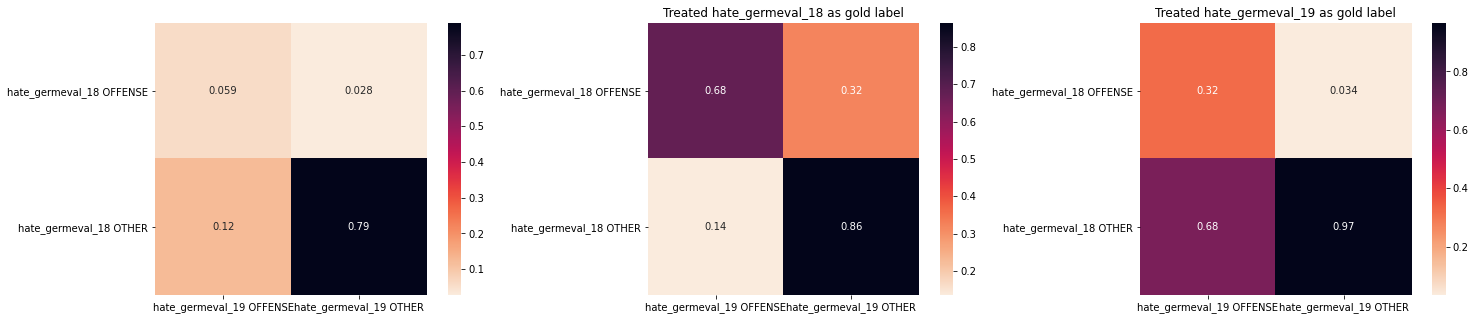

In [53]:
print_confusion_matrices_binary('hate_germeval_18', 'hate_germeval_19')

As one can see in the third plot only 32% of the messages classified offensive by the 19 classifier are also classified offensive by the 18 classifier.

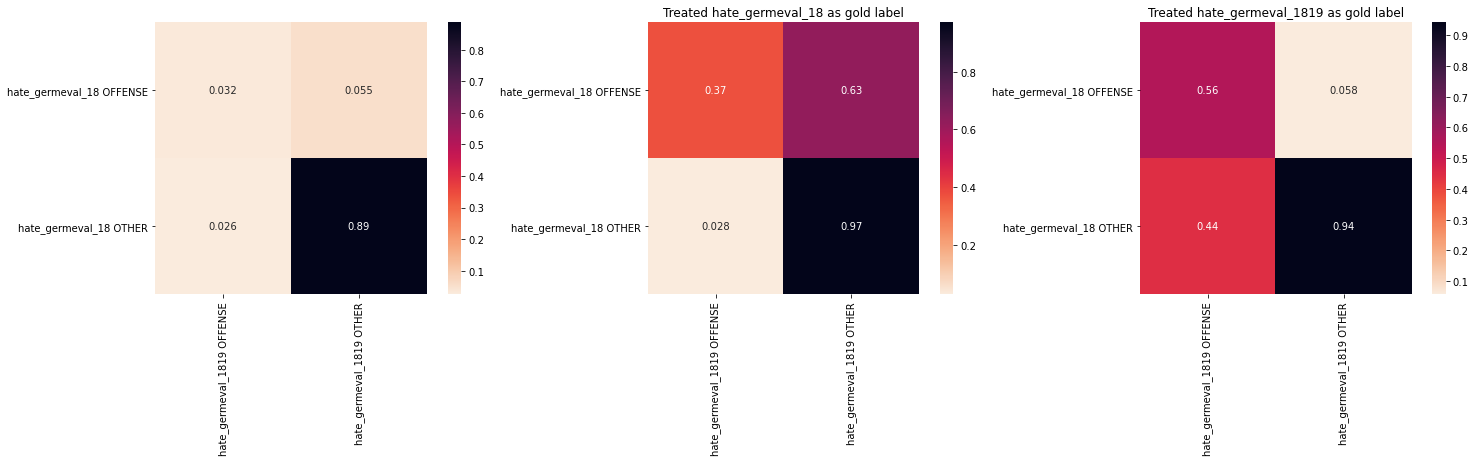

In [54]:
print_confusion_matrices_binary('hate_germeval_18', 'hate_germeval_1819')

Here it becomes clear that the 18 classifier and the 1819 classifer seems to have quite a different understanding of hate. Only 37% of the messages classified as offensive by the 18 classifer are also classified as offensive by the 1819 classifer and 44% of the messages classified as ffensive by the 1819 classifier are also classified as offensive by the 18 classifier.

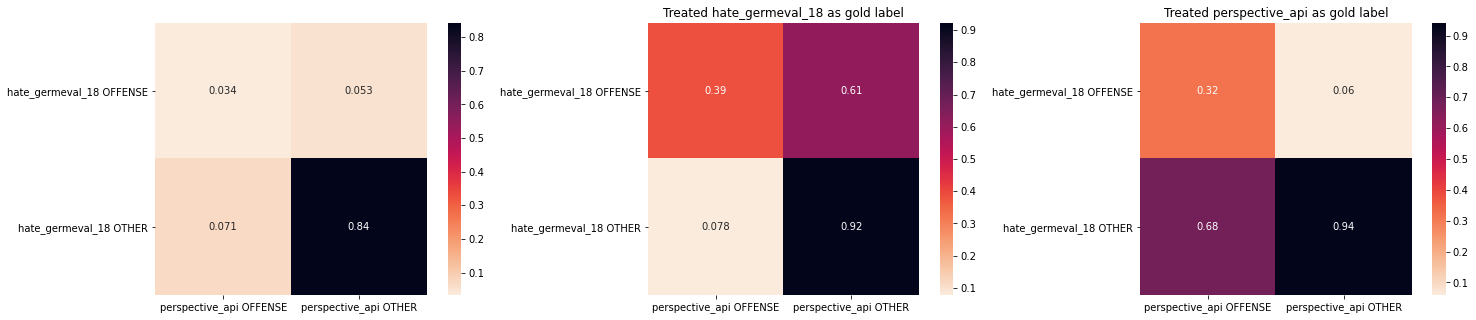

In [55]:
print_confusion_matrices_binary('hate_germeval_18', 'perspective_api')

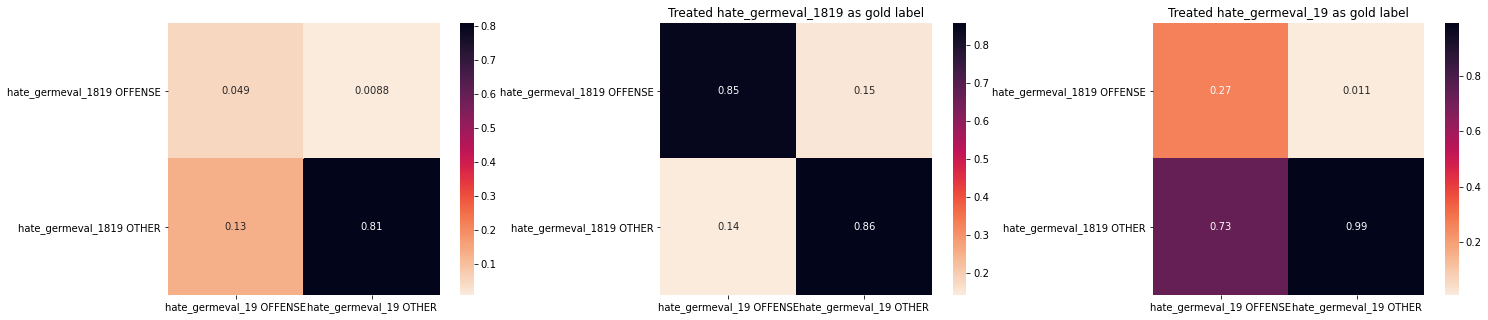

In [56]:
print_confusion_matrices_binary('hate_germeval_1819', 'hate_germeval_19')

It seems that the 1819 and the 19 classifier have a very similar understanding of hate (second plot), the 19 classifier is just more strict.

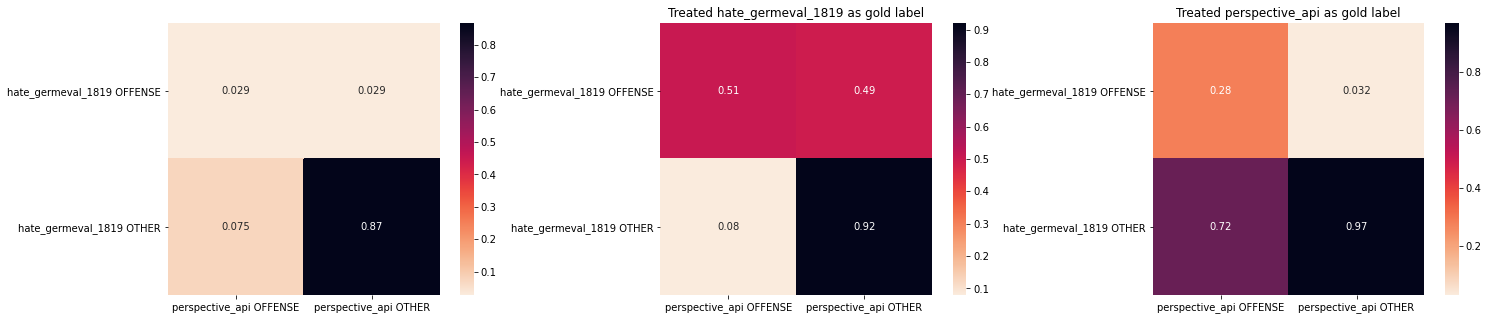

In [57]:
print_confusion_matrices_binary('hate_germeval_1819', 'perspective_api')

In [ ]:
print_confusion_matrices_binary('hate_germeval_19', 'perspective_api')

In [23]:
def get_messages_with_different_label(offensive_label_classifier, other_label_classifier, num_messages):
    l = []
    for msg in messages:
        label_offensive = get_label(msg, offensive_label_classifier)
        label_other = get_label(msg, other_label_classifier)
        if label_offensive == 'OFFENSE' and label_other == 'OTHER':
            l.append(msg['text'])
            if len(l) == num_messages:
                return l
    return l

In [25]:
classifiers = ['hate_germeval_18', 'hate_germeval_19', 'hate_germeval_1819', 'perspective_api']
for classifier_offensive in classifiers:
    for classifier_other in classifiers:
        if classifier_offensive == classifier_other:
            continue
        print('----------' + classifier_offensive + ', ' + classifier_other + '-----------')
        for msg in get_messages_with_different_label(classifier_offensive, classifier_other, 5):
            print(msg + '\n')

----------hate_germeval_18, hate_germeval_19-----------
Unsere Getränkeempfehlung für die kalten Tage:
https://arcadi-online.de/die-feuerzangenbowle-heisse-tradition-oder-reaktionaerer-kopfschmerzsaft/

+++ EILT: LINKSUNTEN BLEIBT VERBOTEN +++
Das Gericht in Leipzig hat entschieden: Die Klage der "linksunten"-Betreiber gegen das Verbot im Jahr 2017 wurde gerade eben abgewiesen – damit bleibt die linksextreme Netzseite verboten. Gut so!

Deutschlands Hoffnungen auf einen ständigen Sitz im UNO-Sicherheitsrat sind zerstoben
@AntiSpiegel
: 
weiter lesen

KRIMINALITÄT AUSSER KONTROLLE
USA: Migrantenkrise und die Macht der Drogenkartelle – Texas macht Biden für Chaos verantwortlich
Drogenschmuggel, Menschenhandel und Kartelle beherrschen die US-Grenze. Es ist eine hochexplosive Mischung. Chaotische Szenen, die aus einem Hollywoodstreifen stammen könnten, werden immer mehr zur Realität. Wird die neue US-Regierung den gewaltigen Migrantenstrom und die Einwanderung zahlreicher Bandenmitglieder 

# 2. Fine Grained Hate Classification
Now we will have a look at the second classification task with the four categories 'PROFANITY', 'INSULT', 'ABUSE', and 'OTHER'. We can not compare the germeval classifiers to the Perspective API as the Perspective API returns a toxicity score which can be only interpreted as a binary classification.

In [3]:
messages_collection = client.telegram.messages


def get_all_german_messages_task_2():
    query = {"language" : "de"}
    query_res = messages_collection.find(query, {"_id": 0, "text": 1, "hate_germeval_18_task_2": 1,
                                                 "hate_germeval_19_task_2": 1, "hate_germeval_1819_task_2": 1})
    messages = [msg for msg in query_res if msg['text'] is not None]
    return messages

In [4]:
messages = get_all_german_messages_task_2()
print(len(messages))

5439691


In [5]:
datasets = ['hate_germeval_18_task_2', 'hate_germeval_19_task_2', 'hate_germeval_1819_task_2']
for dataset in datasets:
    print(dataset, get_number_of_offensive_messages(messages, dataset))

NameError: name 'get_number_of_offensive_messages' is not defined

Again the classifier trained solely on the Germeval 2019 dataset is by far the most strict one, it classifies approximately twice as much messages as offensive as the other classifiers.

In [8]:
similarity_matrix = np.zeros((len(datasets), len(datasets)))
for msg in messages:
    label_18 = get_label(msg, 'hate_germeval_18_task_2')
    label_19 = get_label(msg, 'hate_germeval_19_task_2')
    label_1819 = get_label(msg, 'hate_germeval_1819_task_2')
    labels = [label_18, label_19, label_1819]
    for idx_1, label_1 in enumerate(labels):
        for idx_2, label_2 in enumerate(labels):
            if label_1 == label_2:
                similarity_matrix[idx_1][idx_2] += 1

similarity_matrix = similarity_matrix / len(messages)

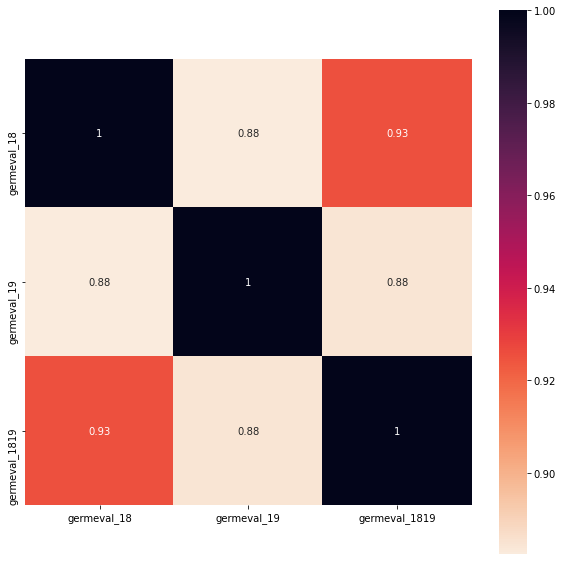

In [9]:
ticklabels = ['germeval_18', 'germeval_19', 'germeval_1819']
ax = sns.heatmap(similarity_matrix, cmap='rocket_r', annot=True, square=True,xticklabels=ticklabels
                     , yticklabels=ticklabels)
figure = plt.gcf()
figure.set_size_inches(10, 10)
plt.show()

The classifiers are even more similar than in the binary classification task, however, again the classifier trained on the Germeval 2019 dataset is slightly different than the other two classifiers.

In [10]:
def get_confusion_matrix_task_2(classifier_1, classifier_2):
    matrix = np.zeros((4, 4))
    for msg in messages:
        label_1 = get_label(msg, classifier_1)
        label_2 = get_label(msg, classifier_2)
        
        def get_idx(label):
            if label == 'OTHER':
                return 0
            if label == 'PROFANITY':
                return 1
            if label == 'INSULT':
                return 2
            return 3
        
        matrix[get_idx(label_1)][get_idx(label_2)] += 1
    return matrix / len(messages)

In [14]:
def print_confusion_matrices(classifier_1, classifier_2):
    confusion_matrix = get_confusion_matrix_task_2(classifier_1, classifier_2)
    ax = sns.heatmap(confusion_matrix, cmap='rocket_r', annot=True, square=True,
                     xticklabels=[classifier_2 + ' OTHER', classifier_2 + ' PROFANITY', 
                                  classifier_2 + ' INSULT', classifier_2 + ' ABUSE']
                    , yticklabels=[classifier_1 + ' OTHER', classifier_1 + ' PROFANITY', 
                                 classifier_1 + ' INSULT', classifier_1 + ' ABUSE'])
    figure = plt.gcf()
    figure.set_size_inches(7, 7)
    plt.show()
        
    print('Treat ' + classifier_1 + ' as gold label:')
    ax = sns.heatmap(confusion_matrix / confusion_matrix.sum(axis=1)[:,np.newaxis], cmap='rocket_r', annot=True, square=True,
                     xticklabels=[classifier_2 + ' OTHER', classifier_2 + ' PROFANITY', 
                                 classifier_2 + ' INSULT', classifier_2 + ' ABUSE']
                 , yticklabels=[classifier_1 + ' OTHER', classifier_1 + ' PROFANITY', 
                                 classifier_1 + ' INSULT', classifier_1 + ' ABUSE'])
    figure = plt.gcf()
    figure.set_size_inches(7, 7)
    plt.show()
    
    print('Treat ' + classifier_2 + ' as gold label:')
    ax = sns.heatmap(confusion_matrix / confusion_matrix.sum(axis=0), cmap='rocket_r', annot=True, square=True,
                     xticklabels=[classifier_2 + ' OTHER', classifier_2 + ' PROFANITY', 
                                 classifier_2 + ' INSULT', classifier_2 + ' ABUSE']
                 , yticklabels=[classifier_1 + ' OTHER', classifier_1 + ' PROFANITY', 
                                 classifier_1 + ' INSULT', classifier_1 + ' ABUSE'])
    figure = plt.gcf()
    figure.set_size_inches(7, 7)
    plt.show()

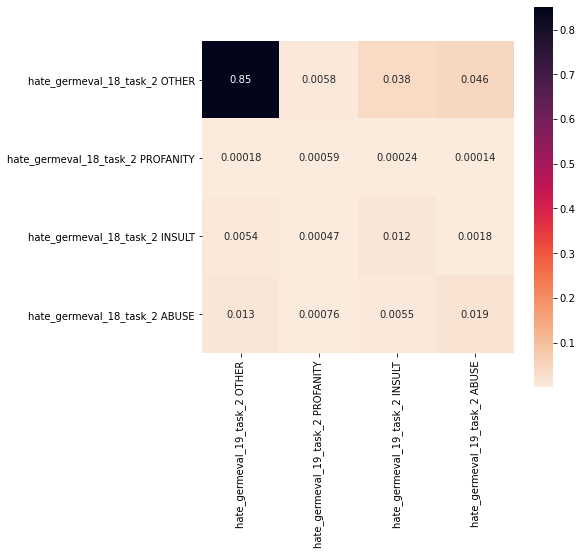

Treat hate_germeval_18_task_2 as gold label:


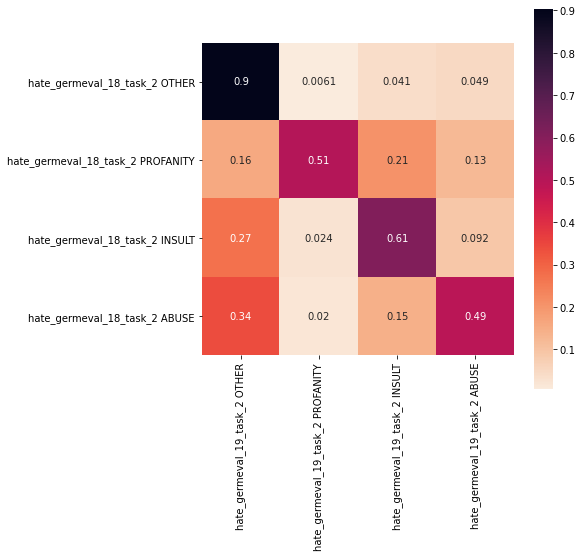

Treat hate_germeval_19_task_2 as gold label:


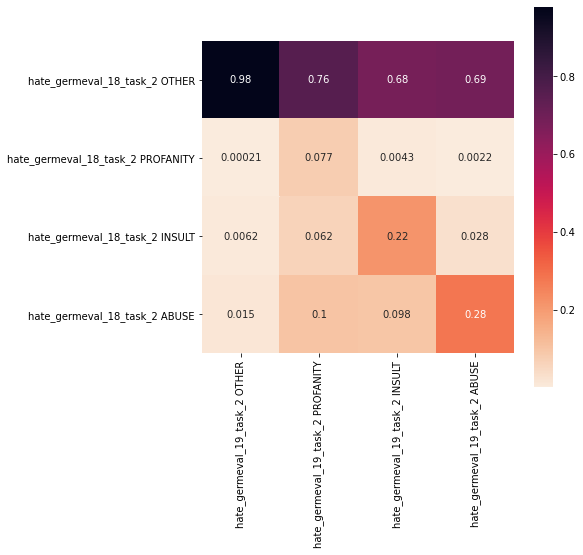

In [16]:
print_confusion_matrices('hate_germeval_18_task_2', 'hate_germeval_19_task_2')

In the third plot one can see that the Germeval 18 classifier is much more tolerant than the Germeval 19 classifier

* 69% of the messages that the 19 classifier classified as ABUSE, the 18 classifier classified as OTHER
* 68% of the messages that the 19 classifier classified as INSULT, the 18 classifier classified as OTHER
* 76% of the messages that the 19 classifier classified as PROFANITY, the 18 classifier classified as OTHER

However, from the second plot we can also see that only 49% of the messages that the 18 classifier classified as ABUSE were also classified as ABUSE by the 19 classifier.

-> this means that the two classifiers have quite a different understanding of hate

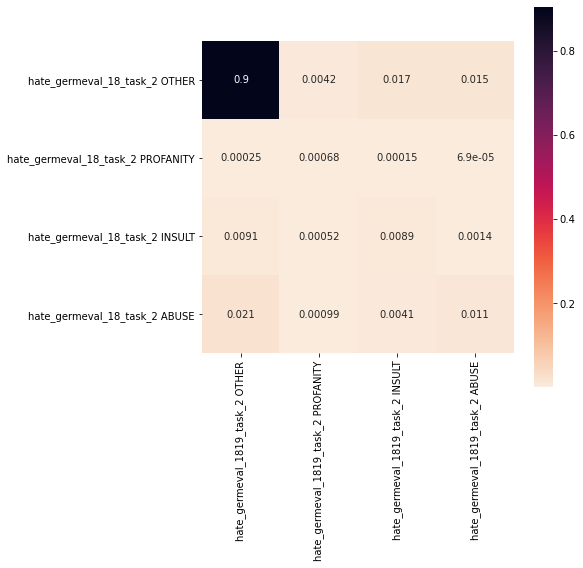

Treat hate_germeval_18_task_2 as gold label:


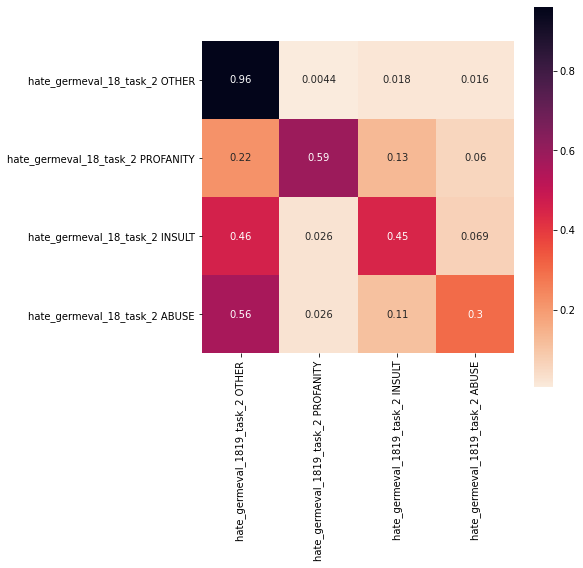

Treat hate_germeval_1819_task_2 as gold label:


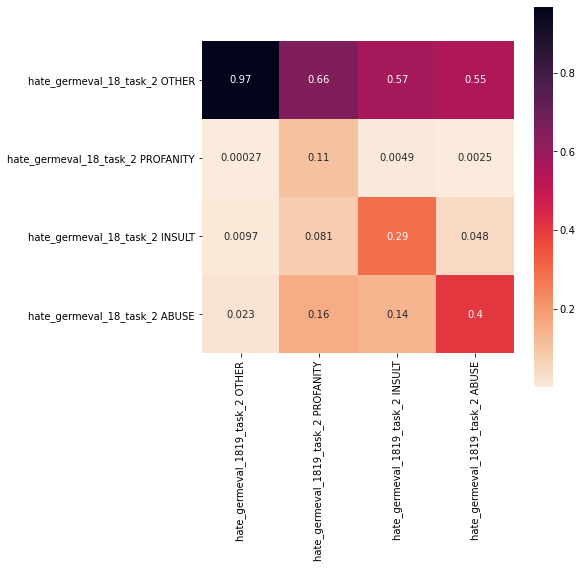

In [17]:
print_confusion_matrices('hate_germeval_18_task_2', 'hate_germeval_1819_task_2')

Again one can see that the two classifiers seem to have a different understanding of hate, however they are more similar than the 18 and 19 classifiers

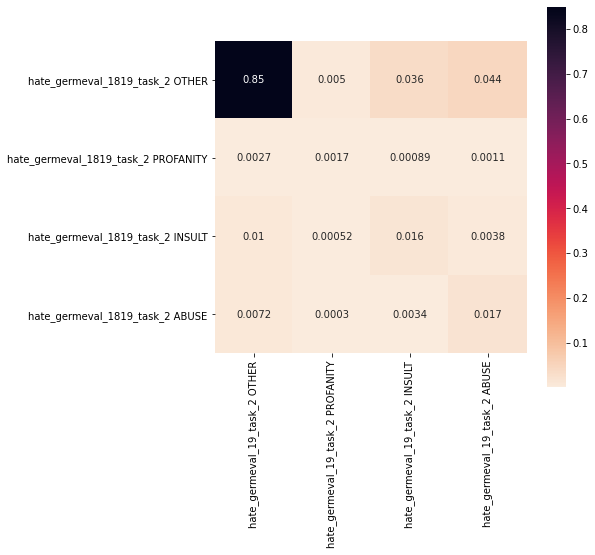

Treat hate_germeval_1819_task_2 as gold label:


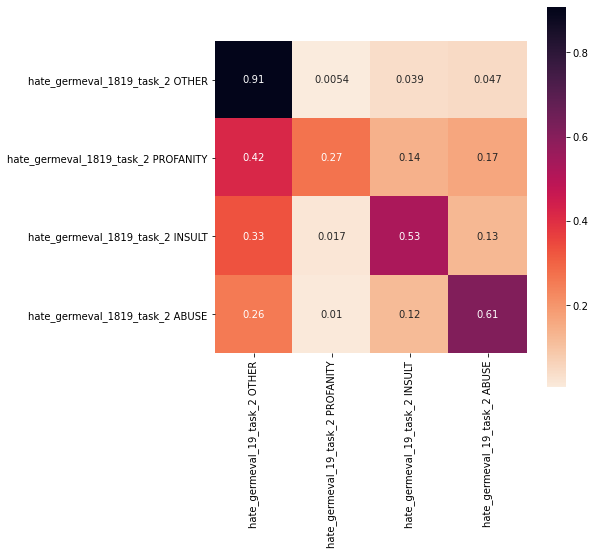

Treat hate_germeval_19_task_2 as gold label:


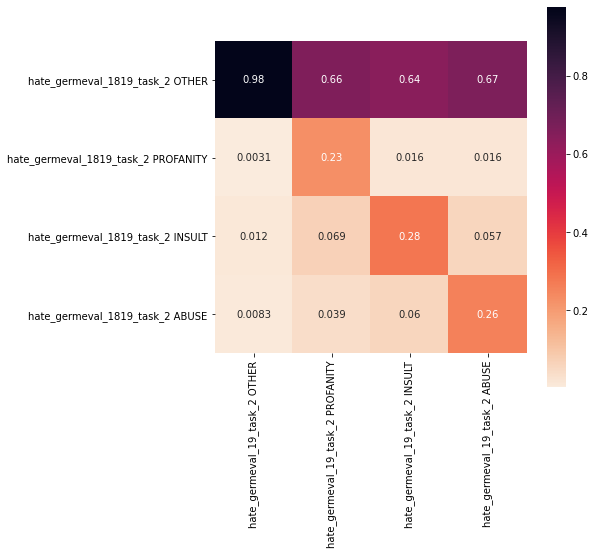

In [19]:
print_confusion_matrices('hate_germeval_1819_task_2', 'hate_germeval_19_task_2')

Again it is clear that the 19 classifier is more strict than the 1819 classifier (high numbers in the first row of the third plot)